# Max 2-Sat

For the problem representation we used a standard format, widely accepted for boolean formulas in CNF, called [DIMACS](https://www.cs.utexas.edu/users/moore/acl2/manuals/current/manual/index-seo.php/SATLINK____DIMACS).

`usage` : change `PATH` variable, in the cell containing parameters, to choose the file of the problem you want to solve



In [14]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from neal import SimulatedAnnealingSampler

import numpy as np
import dwavebinarycsp
import dimod
import itertools 
import minorminer
import networkx as nx
import dwave_networkx as dnx

In [16]:
# parameters

TOKEN = 'DEV-dadab771e1ad528a25146defb4c58b1e0fe50b33' # API dwave
PATH = 'testing_sat/02-sat.txt' # current problem to solve
NUM_READS_SQA = 20
NUM_READS_QPU = 20
CHAIN_STRENGTH = 8

# Create QUBO

In order to create the QUBO of a MAX 2 SAT problem we followed [Glover 2019](https://arxiv.org/pdf/1811.11538.pdf). The formulas to convert traditional constraints into quadratic penalties can be found on page 15:


1. No negations: 
    Example $\left(x_{i} \vee x_{j}\right)$ 
    * Traditional constraint: $x_{i}+x_{j} \geq 1$ 
    * Quadratic Penalty: $\left(1-x_{i}-x_{j}+x_{i} x_{j}\right)$
2. One negation:
    Example $\left(x_{i} \vee \bar{x}_{j}\right)$
    * Traditional constraint: $x_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{j}-x_{i} x_{j}\right)$
3. Two negations: 
    Example $\left(\bar{x}_{i} \vee \bar{x}_{j}\right)$ 
    * Traditional constraint: $\bar{x}_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{i} x_{j}\right)$


In [17]:
# extract clauses and num of variables from 

def extract_clauses(path):
    with open(path, "r") as f:
        # retrieve data from file
        sat = f.readlines()
        data = sat[0].split(" ")

    n_variables = int(data[2]) 

    sat = sat[1:]
    clauses = [x.replace(' 0\n', '') for x in sat]
    
    return clauses, n_variables

clauses, n_variables = extract_clauses(PATH) 
print(f'num_clauses {len(clauses)}')
print('-' * 30)  
print(f'num var {n_variables}')  
print('-' * 30)  
print(f'clauses {clauses}')  

num_clauses 12
------------------------------
num var 4
------------------------------
clauses ['1 2', '1 -2', '-1 2', '-1 -2', '-1 3', '-1 -3', '2 -3', '2 4', '-2 3', '-2 -3', '3 4', '-3 -4']


In [18]:
# generate the matrix Q and c

def gen_q(clauses, n_variables):
    
    Q = np.zeros(shape=(n_variables, n_variables))
    c = 0
    QUBO_graph = nx.Graph()
    for clause in clauses:
        clause = clause.split(' ')
        int_clause = [int(c) for c in clause]

        s1, s2 = int_clause[0], int_clause[1]
        v1, v2 = abs(s1)-1, abs(s2)-1
        QUBO_graph.add_edge(abs(s1), abs(s2))

        if s1 > 0 and s2 > 0: # True True
            # 1 - x1 - x2 + x1x2
            c += 1
            Q[v1][v1] += -1 
            Q[v2][v2] += -1
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2
        elif s1 > 0 and s2 < 0: # True False
            # x2 - x1x2
            Q[v2][v2] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 > 0: # False True
            # x1 - x1x2
            Q[v1][v1] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 < 0: # False False
            # x1x2
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2

        else:
            pass # throw error
            
    return Q, c, QUBO_graph

Q, c, QUBO_graph = gen_q(clauses, n_variables)

print(f'Q is: \n{Q}')
print('-' * 40)
print(f'c is: {c}')

Q is: 
[[ 1.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.5]
 [ 0.  -0.5  0.   1. ]
 [ 0.   0.5  1.  -2. ]]
----------------------------------------
c is: 3


## Create BQM

In [21]:
# Create BQM
variable_order = ["x_{}".format(n) for n in range(1, n_variables+1)]
BQM = dimod.BinaryQuadraticModel.from_numpy_matrix(Q, variable_order = variable_order)
BQM

BinaryQuadraticModel({x_1: 1.0, x_2: 0.0, x_3: 0.0, x_4: -2.0}, {('x_2', 'x_3'): -1.0, ('x_2', 'x_4'): 1.0, ('x_3', 'x_4'): 2.0}, 0.0, 'BINARY')

# Solve

We now solve the problem through both simulated and real quantum annealing showing the results obtained.  

In [22]:
def print_response_data(response):
    # ------- Print results to user -------
    print('-' * 160)
    print('{:>40s}{:>40s}{:^40s}{:^40s}'.format('Set 0','Set 1','Energy',"Count"))
    print('-' * 160)
    for sample, E, occ in response.data(fields=['sample','energy',"num_occurrences"]):
        S0 = [k for k,v in sample.items() if v == 0]
        S1 = [k for k,v in sample.items() if v == 1]
        print('{:>40s}{:>40s}{:^40s}{:^40s}'.format(str(S0),str(S1),str(E),str(occ)))

## Simulated Quantum Annealing

In [24]:
def simulated_annealing(bqm):
    sampler = SimulatedAnnealingSampler()
    response_SQA = sampler.sample(bqm, num_reads=NUM_READS_SQA, chain_strength=CHAIN_STRENGTH)
    return response_SQA

## Real Quantum Annealing

In [25]:
def real_annealing(bqm):
    sampler = EmbeddingComposite(DWaveSampler(token=TOKEN))
    response_QPU = sampler.sample(bqm, num_reads=NUM_READS_QPU, chain_strength=CHAIN_STRENGTH)
    return response_QPU

# Results
In the result we select the most frequent solution and we show both the optimal number of unsatisfied constraints and the assignment of the optimal solution

In [43]:
# retrieve result with the best counts

def return_solution(response, Q, c):
    count = 0
    for i in range(len(response)):
        new_count = response[i][2]
        if  new_count > count:
            best = response[i][0]
            count = new_count
    
    y = c + np.matmul(np.matmul(best.T, Q), best) 

    return y, best

def print_solution(response, Q, c):
    y, best = return_solution(response.aggregate().record, Q, c)
    print(f'y is {int(y)} (optimal number of unsitisfied constraints)')

    for v in range(n_variables):
        print(f'x_{v+1} = {True if best[v] else False}')

def compare_simulation_real(resp_simulation, resp_real, Q, c):
    y_sim, best_sim = return_solution(resp_simulation.aggregate().record, Q, c)
    y_real, best_real = return_solution(resp_real.aggregate().record, Q, c)
    print(f'y simulation is {int(y_sim)}, y real is {int(y_real)} (optimal number of unsitisfied constraints)')

    sim_assignment = [best_sim[v] for v in range(n_variables)]
    real_assignment = [best_real[v] for v in range(n_variables)]

    count = 0
    for s, r in zip(sim_assignment, real_assignment):
        if r != s: 
            count += 1

    print(f'real and simulation assignment differ by: {count}')

## Simulated Quantum Annealing

In [44]:
response_SQA = simulated_annealing(BQM)

In [45]:
print_response_data(response_SQA.aggregate())

----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                   ['x_1', 'x_2', 'x_3']                                 ['x_4']                  -2.0                                     20                   


In [46]:
print_solution(response_SQA, Q, c)

y is 1 (optimal number of unsitisfied constraints)
x_1 = False
x_2 = False
x_3 = False
x_4 = True


## Real Quantum Annealing


In [47]:
response_QPU = real_annealing(BQM)

In [48]:
print_response_data(response_QPU)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                   ['x_1', 'x_2', 'x_3']                                 ['x_4']                  -2.0                                     20                   


In [49]:
print_solution(response_QPU, Q, c)

y is 1 (optimal number of unsitisfied constraints)
x_1 = False
x_2 = False
x_3 = False
x_4 = True


# Number of required Qubits

In [50]:
device = DWaveSampler(token=TOKEN)
device.solver.data['id']

QPU_graph = device.solver.data['properties']["couplers"]

embedded_graph = minorminer.find_embedding(QUBO_graph.edges(), QPU_graph)

embedded_graph

{1: [1175], 2: [1190], 3: [4026], 4: [4041]}

In [51]:
sublist = [values for keys, values in embedded_graph.items()]
flat_list = set(itertools.chain(*sublist))    

max_chain_length = None
min_chain_length = None

for _, chain in embedded_graph.items():
    if max_chain_length is None:
        max_chain_length = len(chain)
        min_chain_length = len(chain)

    if len(chain) > max_chain_length:
        max_chain_length = len(chain)

    if len(chain) < min_chain_length:
        min_chain_length = len(chain)

    
print("Embedding requires {} qubits and has chain lengths between {}-{}".format(len(flat_list),min_chain_length, max_chain_length))

Embedding requires 4 qubits and has chain lengths between 1-1


# Visualization

In [52]:
# solutions comparison
compare_simulation_real(response_SQA, response_QPU, Q, c)

y simulation is 1, y real is 1 (optimal number of unsitisfied constraints)
real and simulation assignment differ by: 0


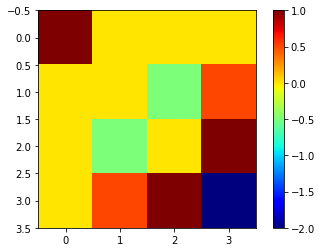

In [53]:
from matplotlib import pyplot as plt

plt.imshow(Q, cmap='jet')
plt.colorbar()

# Testing

In [61]:
time_labels = [
'qpu_sampling_time', 
'qpu_anneal_time_per_sample', 
'qpu_readout_time_per_sample', 
'qpu_access_time', 
'qpu_access_overhead_time', 
'qpu_programming_time', 
'qpu_delay_time_per_sample', 
'total_post_processing_time', 
'post_processing_overhead_time'
]

total_time = 0
for t in time_labels:
    time = response_QPU.info["timing"][t]
    print(f'{t}: {time}μs')
    total_time += time
print(f'total time: {total_time}μs') 

qpu_sampling_time: 1618μs
qpu_anneal_time_per_sample: 20μs
qpu_readout_time_per_sample: 40μs
qpu_access_time: 17424μs
qpu_access_overhead_time: 12819μs
qpu_programming_time: 15806μs
qpu_delay_time_per_sample: 21μs
total_post_processing_time: 422μs
post_processing_overhead_time: 422μs
total time: 48592μs


# Benchmarks Report 
We tested our implementation with a total of 228 tests, with different number of variables and clauses. In particular we tested for:
- 120, 140, 160, 180, 200 variables
- 1200 to 2600 clauses

Benchmarks for the max2sat testing are taken from [here](http://maxsat.ia.udl.cat/benchmarks/)

results can be found [here](http://maxsat.ia.udl.cat/detailed/complete-ms-random-table.html)

we report them for simpplicity: (we report only the best optimal result from the best solver for the benchmark)

| Label |                                            Meaning                                           |
|:-----:|:--------------------------------------------------------------------------------------------:|
| S     | Solution {OPTIMUM FOUND or OPT \| UNSATISFIABLE or UNSAT \| UNKNOWN \| Not available or N/A} |
| O     | Best solution found                                                                          |
| T     | CPU time (TO for Time Out)                                                                   |

Below the results for each benchmark, here we reported only QPU programming time and sampling time for simplicity.
For a detailed view on all the time for each experiment check q_solutions.txt file.


| Benchmark | S | O | T | O_SA | O_RA | QPU programming time | QPU sampling time |
|:---------:|:-:|:-:|:-:|:----:|:----:|:--------------------:|:-----------------:|
|s2v120c1200-1.cnf|S=OPT | O=161 | T=5.65 | O_SA=324.0 | O_RA=312.0 | Tp=15805 | Ts=2735 |
|s2v120c1200-2.cnf|S=OPT | O=159 | T=8.40 | O_SA=299.0 | O_RA=289.0 | Tp=15816 | Ts=3114 |
|s2v120c1200-3.cnf|S=OPT | O=160 | T=2.70 | O_SA=294.0 | O_RA=290.0 | Tp=15794 | Ts=2804 |
|s2v120c1300-1.cnf|S=OPT | O=180 | T=14.94 | O_SA=355.0 | O_RA=325.0 | Tp=15800 | Ts=3302 |
|s2v120c1300-2.cnf|S=OPT | O=172 | T=6.29 | O_SA=312.0 | O_RA=305.0 | Tp=15794 | Ts=2965 |
|s2v120c1300-3.cnf|S=OPT | O=173 | T=5.96 | O_SA=334.0 | O_RA=307.0 | Tp=15812 | Ts=2789 |
|s2v120c1400-1.cnf|S=OPT | O=197 | T=17.17 | O_SA=374.0 | O_RA=368.0 | Tp=15806 | Ts=3264 |
|s2v120c1400-2.cnf|S=OPT | O=191 | T=10.06 | O_SA=349.0 | O_RA=338.0 | Tp=15814 | Ts=2897 |
|s2v120c1400-3.cnf|S=OPT | O=189 | T=8.30 | O_SA=378.0 | O_RA=381.0 | Tp=15812 | Ts=3315 |
|s2v120c1500-1.cnf|S=OPT | O=211 | T=8.00 | O_SA=390.0 | O_RA=401.0 | Tp=15799 | Ts=3196 |
|s2v120c1500-2.cnf|S=OPT | O=213 | T=27.02 | O_SA=370.0 | O_RA=390.0 | Tp=15807 | Ts=3180 |
|s2v120c1500-3.cnf|S=OPT | O=207 | T=6.18 | O_SA=378.0 | O_RA=394.0 | Tp=15807 | Ts=3257 |
|s2v120c1600-1.cnf|S=OPT | O=233 | T=24.19 | O_SA=427.0 | O_RA=408.0 | Tp=15798 | Ts=2952 |
|s2v120c1600-2.cnf|S=OPT | O=239 | T=85.74 | O_SA=389.0 | O_RA=402.0 | Tp=15798 | Ts=2942 |
|s2v120c1600-3.cnf|S=OPT | O=233 | T=29.73 | O_SA=403.0 | O_RA=405.0 | Tp=15789 | Ts=3070 |
|s2v120c1700-1.cnf|S=OPT | O=257 | T=51.12 | O_SA=431.0 | O_RA=459.0 | Tp=15809 | Ts=3087 |
|s2v120c1700-2.cnf|S=OPT | O=248 | T=66.38 | O_SA=421.0 | O_RA=406.0 | Tp=15803 | Ts=2885 |
|s2v120c1700-3.cnf|S=OPT | O=239 | T=5.69 | O_SA=444.0 | O_RA=454.0 | Tp=15809 | Ts=2938 |
|s2v120c1800-1.cnf|S=OPT | O=291 | T=383.01 | O_SA=461.0 | O_RA=464.0 | Tp=15803 | Ts=3350 |
|s2v120c1800-2.cnf|S=OPT | O=262 | T=16.59 | O_SA=436.0 | O_RA=481.0 | Tp=15801 | Ts=3235 |
|s2v120c1800-3.cnf|S=OPT | O=279 | T=64.81 | O_SA=459.0 | O_RA=441.0 | Tp=15813 | Ts=3142 |
|s2v120c1900-1.cnf|S=OPT | O=293 | T=64.83 | O_SA=491.0 | O_RA=492.0 | Tp=15798 | Ts=3266 |
|s2v120c1900-2.cnf|S=OPT | O=296 | T=144.99 | O_SA=478.0 | O_RA=478.0 | Tp=15793 | Ts=2829 |
|s2v120c1900-3.cnf|S=OPT | O=294 | T=88.19 | O_SA=499.0 | O_RA=476.0 | Tp=15803 | Ts=3018 |
|s2v120c2000-1.cnf|S=OPT | O=307 | T=27.04 | O_SA=489.0 | O_RA=500.0 | Tp=15808 | Ts=3050 |
|s2v120c2000-2.cnf|S=OPT | O=321 | T=651.59 | O_SA=513.0 | O_RA=512.0 | Tp=15805 | Ts=2842 |
|s2v120c2000-3.cnf|S=OPT | O=307 | T=71.32 | O_SA=474.0 | O_RA=472.0 | Tp=15801 | Ts=2940 |
|s2v120c2100-1.cnf|S=OPT | O=336 | T=64.23 | O_SA=513.0 | O_RA=492.0 | Tp=15804 | Ts=3279 |
|s2v120c2100-2.cnf|S=OPT | O=336 | T=691.62 | O_SA=508.0 | O_RA=505.0 | Tp=15801 | Ts=3241 |
|s2v120c2100-3.cnf|S=OPT | O=332 | T=214.08 | O_SA=542.0 | O_RA=487.0 | Tp=15801 | Ts=2821 |
|s2v120c2200-1.cnf|S=OPT | O=358 | T=446.53 | O_SA=559.0 | O_RA=547.0 | Tp=15798 | Ts=3378 |
|s2v120c2200-2.cnf|S=OPT | O=371 | T=1530.60 | O_SA=532.0 | O_RA=560.0 | Tp=15801 | Ts=3058 |
|s2v120c2200-3.cnf|S=OPT | O=359 | T=336.23 | O_SA=561.0 | O_RA=573.0 | Tp=15794 | Ts=2914 |
|s2v120c2300-1.cnf|S=OPT | O=380 | T=384.48 | O_SA=550.0 | O_RA=554.0 | Tp=15825 | Ts=3425 |
|s2v120c2300-2.cnf|S=OPT | O=383 | T=599.46 | O_SA=570.0 | O_RA=569.0 | Tp=15786 | Ts=3389 |
|s2v120c2300-3.cnf|S=OPT | O=365 | T=80.14 | O_SA=554.0 | O_RA=519.0 | Tp=15810 | Ts=3181 |
|s2v120c2400-1.cnf|S=OPT | O=389 | T=154.85 | O_SA=617.0 | O_RA=596.0 | Tp=15801 | Ts=2930 |
|s2v120c2400-2.cnf|S=OPT | O=402 | T=958.04 | O_SA=596.0 | O_RA=596.0 | Tp=15806 | Ts=3152 |
|s2v120c2400-3.cnf|S=OPT | O=380 | T=41.53 | O_SA=624.0 | O_RA=606.0 | Tp=15805 | Ts=3226 |
|s2v120c2500-1.cnf|S=OPT | O=418 | T=256.04 | O_SA=605.0 | O_RA=606.0 | Tp=15806 | Ts=3122 |
|s2v120c2500-2.cnf|S=N/A | O=N/A | T=TO | O_SA=620.0 | O_RA=622.0 | Tp=15805 | Ts=3315 |
|s2v120c2500-3.cnf|S=OPT | O=425 | T=898.11 | O_SA=656.0 | O_RA=626.0 | Tp=15805 | Ts=3404 |
|s2v120c2600-1.cnf|S=OPT | O=439 | T=877.77 | O_SA=687.0 | O_RA=654.0 | Tp=15813 | Ts=3390 |
|s2v120c2600-2.cnf|S=N/A | O=N/A | T=TO | O_SA=620.0 | O_RA=643.0 | Tp=15817 | Ts=3030 |
|s2v120c2600-3.cnf|S=OPT | O=440 | T=447.94 | O_SA=618.0 | O_RA=643.0 | Tp=15805 | Ts=3449 |
|s2v140c1200-1.cnf|S=OPT | O=144 | T=6.48 | O_SA=302.0 | O_RA=269.0 | Tp=15804 | Ts=3121 |
|s2v140c1200-2.cnf|S=OPT | O=155 | T=156.32 | O_SA=329.0 | O_RA=308.0 | Tp=15819 | Ts=3032 |
|s2v140c1200-3.cnf|S=OPT | O=155 | T=17.66 | O_SA=274.0 | O_RA=282.0 | Tp=15809 | Ts=3310 |
|s2v140c1300-1.cnf|S=OPT | O=162 | T=23.75 | O_SA=314.0 | O_RA=308.0 | Tp=15801 | Ts=3086 |
|s2v140c1300-2.cnf|S=OPT | O=171 | T=109.37 | O_SA=326.0 | O_RA=344.0 | Tp=15804 | Ts=2919 |
|s2v140c1300-3.cnf|S=OPT | O=168 | T=30.82 | O_SA=309.0 | O_RA=334.0 | Tp=15791 | Ts=3147 |
|s2v140c1400-1.cnf|S=OPT | O=182 | T=46.33 | O_SA=333.0 | O_RA=353.0 | Tp=15795 | Ts=2969 |
|s2v140c1400-2.cnf|S=OPT | O=178 | T=24.86 | O_SA=316.0 | O_RA=358.0 | Tp=15809 | Ts=3164 |
|s2v140c1400-3.cnf|S=OPT | O=193 | T=144.40 | O_SA=329.0 | O_RA=333.0 | Tp=15814 | Ts=3129 |
|s2v140c1500-1.cnf|S=OPT | O=205 | T=145.96 | O_SA=354.0 | O_RA=382.0 | Tp=15800 | Ts=3132 |
|s2v140c1500-2.cnf|S=OPT | O=199 | T=129.94 | O_SA=354.0 | O_RA=364.0 | Tp=15797 | Ts=3374 |
|s2v140c1500-3.cnf|S=OPT | O=212 | T=450.64 | O_SA=352.0 | O_RA=392.0 | Tp=15810 | Ts=3154 |
|s2v140c1600-1.cnf|S=OPT | O=221 | T=99.13 | O_SA=348.0 | O_RA=375.0 | Tp=15799 | Ts=3187 |
|s2v140c1600-2.cnf|S=OPT | O=221 | T=160.58 | O_SA=379.0 | O_RA=400.0 | Tp=15801 | Ts=3299 |
|s2v140c1600-3.cnf|S=OPT | O=226 | T=246.25 | O_SA=385.0 | O_RA=374.0 | Tp=15807 | Ts=2995 |
|s2v140c1700-1.cnf|S=N/A | O=N/A | T=TO | O_SA=447.0 | O_RA=428.0 | Tp=15815 | Ts=3052 |
|s2v140c1700-2.cnf|S=OPT | O=242 | T=206.76 | O_SA=415.0 | O_RA=424.0 | Tp=15803 | Ts=3092 |
|s2v140c1700-3.cnf|S=OPT | O=236 | T=69.70 | O_SA=453.0 | O_RA=436.0 | Tp=15798 | Ts=3102 |
|s2v140c1800-1.cnf|S=OPT | O=254 | T=324.26 | O_SA=459.0 | O_RA=439.0 | Tp=15810 | Ts=2982 |
|s2v140c1800-2.cnf|S=OPT | O=257 | T=132.36 | O_SA=474.0 | O_RA=430.0 | Tp=15813 | Ts=3433 |
|s2v140c1800-3.cnf|S=OPT | O=255 | T=67.50 | O_SA=458.0 | O_RA=410.0 | Tp=15809 | Ts=3317 |
|s2v140c1900-1.cnf|S=N/A | O=N/A | T=TO | O_SA=464.0 | O_RA=469.0 | Tp=15797 | Ts=3318 |
|s2v140c1900-2.cnf|S=OPT | O=273 | T=53.78 | O_SA=467.0 | O_RA=466.0 | Tp=15791 | Ts=3095 |
|s2v140c1900-3.cnf|S=OPT | O=278 | T=268.61 | O_SA=486.0 | O_RA=457.0 | Tp=15807 | Ts=3086 |
|s2v140c2000-1.cnf|S=OPT | O=298 | T=535.22 | O_SA=451.0 | O_RA=474.0 | Tp=15813 | Ts=3356 |
|s2v140c2000-2.cnf|S=OPT | O=308 | T=1178.33 | O_SA=536.0 | O_RA=529.0 | Tp=15800 | Ts=3098 |
|s2v140c2000-3.cnf|S=OPT | O=296 | T=269.67 | O_SA=515.0 | O_RA=496.0 | Tp=15814 | Ts=3050 |
|s2v140c2100-1.cnf|S=OPT | O=293 | T=33.99 | O_SA=485.0 | O_RA=502.0 | Tp=15806 | Ts=3406 |
|s2v140c2100-2.cnf|S=OPT | O=310 | T=190.04 | O_SA=505.0 | O_RA=516.0 | Tp=15787 | Ts=3150 |
|s2v140c2100-3.cnf|S=OPT | O=319 | T=593.53 | O_SA=511.0 | O_RA=545.0 | Tp=15812 | Ts=3021 |
|s2v140c2200-1.cnf|S=OPT | O=336 | T=1014.50 | O_SA=571.0 | O_RA=549.0 | Tp=15793 | Ts=3084 |
|s2v140c2200-2.cnf|S=OPT | O=332 | T=952.96 | O_SA=537.0 | O_RA=528.0 | Tp=15803 | Ts=3334 |
|s2v140c2200-3.cnf|S=OPT | O=329 | T=397.21 | O_SA=562.0 | O_RA=574.0 | Tp=15795 | Ts=3178 |
|s2v140c2300-1.cnf|S=N/A | O=N/A | T=TO | O_SA=574.0 | O_RA=558.0 | Tp=15793 | Ts=3407 |
|s2v140c2300-2.cnf|S=N/A | O=N/A | T=TO | O_SA=581.0 | O_RA=553.0 | Tp=15802 | Ts=3295 |
|s2v140c2300-3.cnf|S=OPT | O=352 | T=880.10 | O_SA=557.0 | O_RA=564.0 | Tp=15781 | Ts=3250 |
|s2v140c2400-1.cnf|S=N/A | O=N/A | T=TO | O_SA=586.0 | O_RA=617.0 | Tp=15807 | Ts=3111 |
|s2v140c2400-2.cnf|S=N/A | O=N/A | T=TO | O_SA=596.0 | O_RA=601.0 | Tp=15790 | Ts=3292 |
|s2v140c2400-3.cnf|S=N/A | O=N/A | T=TO | O_SA=599.0 | O_RA=592.0 | Tp=15798 | Ts=3250 |
|s2v140c2500-1.cnf|S=OPT | O=393 | T=837.06 | O_SA=588.0 | O_RA=586.0 | Tp=15799 | Ts=3362 |
|s2v140c2500-2.cnf|S=N/A | O=N/A | T=TO | O_SA=638.0 | O_RA=616.0 | Tp=15809 | Ts=3399 |
|s2v140c2500-3.cnf|S=N/A | O=N/A | T=TO | O_SA=590.0 | O_RA=625.0 | Tp=15806 | Ts=3038 |
|s2v140c2600-1.cnf|S=N/A | O=N/A | T=TO | O_SA=688.0 | O_RA=644.0 | Tp=15805 | Ts=3347 |
|s2v140c2600-2.cnf|S=N/A | O=N/A | T=TO | O_SA=652.0 | O_RA=630.0 | Tp=15805 | Ts=3157 |
|s2v140c2600-3.cnf|S=OPT | O=406 | T=961.82 | O_SA=644.0 | O_RA=661.0 | Tp=15816 | Ts=3406 |
|s2v160c1200-1.cnf|S=OPT | O=142 | T=43.42 | O_SA=294.0 | O_RA=309.0 | Tp=15821 | Ts=3213 |
|s2v160c1200-2.cnf|S=OPT | O=133 | T=8.96 | O_SA=322.0 | O_RA=309.0 | Tp=15798 | Ts=3064 |
|s2v160c1200-3.cnf|S=OPT | O=143 | T=86.49 | O_SA=296.0 | O_RA=307.0 | Tp=15797 | Ts=3140 |
|s2v160c1300-1.cnf|S=OPT | O=167 | T=337.15 | O_SA=317.0 | O_RA=328.0 | Tp=15799 | Ts=3103 |
|s2v160c1300-2.cnf|S=OPT | O=139 | T=2.90 | O_SA=319.0 | O_RA=338.0 | Tp=15815 | Ts=3236 |
|s2v160c1300-3.cnf|S=OPT | O=157 | T=86.01 | O_SA=303.0 | O_RA=329.0 | Tp=15797 | Ts=3166 |
|s2v160c1400-1.cnf|S=OPT | O=166 | T=36.36 | O_SA=358.0 | O_RA=382.0 | Tp=15803 | Ts=3102 |
|s2v160c1400-2.cnf|S=OPT | O=164 | T=38.99 | O_SA=333.0 | O_RA=365.0 | Tp=15810 | Ts=3151 |
|s2v160c1400-3.cnf|S=OPT | O=167 | T=21.86 | O_SA=350.0 | O_RA=379.0 | Tp=15795 | Ts=3052 |
|s2v160c1500-1.cnf|S=OPT | O=183 | T=14.22 | O_SA=396.0 | O_RA=383.0 | Tp=15807 | Ts=3272 |
|s2v160c1500-2.cnf|S=OPT | O=200 | T=905.90 | O_SA=369.0 | O_RA=365.0 | Tp=15793 | Ts=3268 |
|s2v160c1500-3.cnf|S=OPT | O=184 | T=62.16 | O_SA=389.0 | O_RA=373.0 | Tp=15807 | Ts=3120 |
|s2v160c1600-1.cnf|S=N/A | O=N/A | T=TO | O_SA=405.0 | O_RA=419.0 | Tp=15797 | Ts=3329 |
|s2v160c1600-2.cnf|S=N/A | O=N/A | T=TO | O_SA=386.0 | O_RA=409.0 | Tp=15799 | Ts=3222 |
|s2v160c1600-3.cnf|S=OPT | O=213 | T=743.89 | O_SA=399.0 | O_RA=412.0 | Tp=15791 | Ts=3271 |
|s2v160c1700-1.cnf|S=OPT | O=226 | T=659.70 | O_SA=425.0 | O_RA=428.0 | Tp=15809 | Ts=3225 |
|s2v160c1700-2.cnf|S=OPT | O=230 | T=572.97 | O_SA=412.0 | O_RA=450.0 | Tp=15803 | Ts=3370 |
|s2v160c1700-3.cnf|S=N/A | O=N/A | T=TO | O_SA=435.0 | O_RA=456.0 | Tp=15803 | Ts=3316 |
|s2v160c1800-1.cnf|S=N/A | O=N/A | T=TO | O_SA=426.0 | O_RA=452.0 | Tp=15818 | Ts=3258 |
|s2v160c1800-2.cnf|S=N/A | O=N/A | T=TO | O_SA=440.0 | O_RA=430.0 | Tp=15805 | Ts=3207 |
|s2v160c1800-3.cnf|S=N/A | O=N/A | T=TO | O_SA=465.0 | O_RA=471.0 | Tp=15812 | Ts=3209 |
|s2v160c1900-1.cnf|S=OPT | O=261 | T=1241.31 | O_SA=459.0 | O_RA=465.0 | Tp=15806 | Ts=3205 |
|s2v160c1900-2.cnf|S=OPT | O=262 | T=1480.92 | O_SA=490.0 | O_RA=473.0 | Tp=15805 | Ts=3330 |
|s2v160c1900-3.cnf|S=OPT | O=264 | T=995.23 | O_SA=460.0 | O_RA=483.0 | Tp=15790 | Ts=3404 |
|s2v160c2000-1.cnf|S=N/A | O=N/A | T=TO | O_SA=510.0 | O_RA=491.0 | Tp=15795 | Ts=3220 |
|s2v160c2000-2.cnf|S=OPT | O=272 | T=92.52 | O_SA=526.0 | O_RA=520.0 | Tp=15800 | Ts=3206 |
|s2v160c2000-3.cnf|S=OPT | O=282 | T=790.73 | O_SA=561.0 | O_RA=540.0 | Tp=15794 | Ts=3369 |
|s2v160c2100-1.cnf|S=N/A | O=N/A | T=TO | O_SA=535.0 | O_RA=534.0 | Tp=15807 | Ts=3482 |
|s2v160c2100-2.cnf|S=N/A | O=N/A | T=TO | O_SA=531.0 | O_RA=546.0 | Tp=15807 | Ts=3488 |
|s2v160c2100-3.cnf|S=N/A | O=N/A | T=TO | O_SA=511.0 | O_RA=522.0 | Tp=15799 | Ts=3381 |
|s2v160c2200-1.cnf|S=OPT | O=310 | T=642.57 | O_SA=552.0 | O_RA=506.0 | Tp=15815 | Ts=3433 |
|s2v160c2200-2.cnf|S=N/A | O=N/A | T=TO | O_SA=550.0 | O_RA=529.0 | Tp=15816 | Ts=3384 |
|s2v160c2200-3.cnf|S=N/A | O=N/A | T=TO | O_SA=532.0 | O_RA=530.0 | Tp=15799 | Ts=3399 |
|s2v160c2300-1.cnf|S=N/A | O=N/A | T=TO | O_SA=572.0 | O_RA=569.0 | Tp=15801 | Ts=3394 |
|s2v160c2300-2.cnf|S=N/A | O=N/A | T=TO | O_SA=617.0 | O_RA=591.0 | Tp=15807 | Ts=3350 |
|s2v160c2300-3.cnf|S=N/A | O=N/A | T=TO | O_SA=576.0 | O_RA=561.0 | Tp=15812 | Ts=3420 |
|s2v160c2400-1.cnf|S=N/A | O=N/A | T=TO | O_SA=594.0 | O_RA=618.0 | Tp=15807 | Ts=3397 |
|s2v160c2400-2.cnf|S=N/A | O=N/A | T=TO | O_SA=596.0 | O_RA=568.0 | Tp=15805 | Ts=3404 |
|s2v160c2400-3.cnf|S=N/A | O=N/A | T=TO | O_SA=603.0 | O_RA=574.0 | Tp=15783 | Ts=3433 |
|s2v160c2500-1.cnf|S=N/A | O=N/A | T=TO | O_SA=624.0 | O_RA=626.0 | Tp=15803 | Ts=3456 |
|s2v160c2500-2.cnf|S=N/A | O=N/A | T=TO | O_SA=630.0 | O_RA=650.0 | Tp=15796 | Ts=3459 |
|s2v160c2500-3.cnf|S=N/A | O=N/A | T=TO | O_SA=621.0 | O_RA=631.0 | Tp=15804 | Ts=3470 |
|s2v160c2600-1.cnf|S=OPT | O=392 | T=1596.27 | O_SA=655.0 | O_RA=642.0 | Tp=15801 | Ts=3337 |
|s2v160c2600-2.cnf|S=N/A | O=N/A | T=TO | O_SA=627.0 | O_RA=679.0 | Tp=15809 | Ts=3386 |
|s2v160c2600-3.cnf|S=N/A | O=N/A | T=TO | O_SA=615.0 | O_RA=653.0 | Tp=15806 | Ts=3470 |
|s2v180c1200-1.cnf|S=OPT | O=134 | T=147.86 | O_SA=301.0 | O_RA=293.0 | Tp=15810 | Ts=3125 |
|s2v180c1200-2.cnf|S=OPT | O=130 | T=79.94 | O_SA=275.0 | O_RA=281.0 | Tp=15807 | Ts=3342 |
|s2v180c1200-3.cnf|S=OPT | O=131 | T=156.38 | O_SA=313.0 | O_RA=318.0 | Tp=15812 | Ts=3162 |
|s2v180c1200-4.cnf|S=OPT | O=128 | T=135.96 | O_SA=293.0 | O_RA=301.0 | Tp=15801 | Ts=3236 |
|s2v180c1300-1.cnf|S=OPT | O=153 | T=646.96 | O_SA=321.0 | O_RA=319.0 | Tp=15795 | Ts=3242 |
|s2v180c1300-2.cnf|S=OPT | O=138 | T=43.39 | O_SA=356.0 | O_RA=341.0 | Tp=15798 | Ts=3200 |
|s2v180c1300-3.cnf|S=OPT | O=150 | T=165.80 | O_SA=319.0 | O_RA=314.0 | Tp=15810 | Ts=3266 |
|s2v180c1300-4.cnf|S=OPT | O=149 | T=288.42 | O_SA=309.0 | O_RA=323.0 | Tp=15807 | Ts=3189 |
|s2v180c1400-1.cnf|S=OPT | O=165 | T=433.80 | O_SA=326.0 | O_RA=356.0 | Tp=15801 | Ts=3372 |
|s2v180c1400-2.cnf|S=OPT | O=165 | T=514.80 | O_SA=348.0 | O_RA=333.0 | Tp=15804 | Ts=3241 |
|s2v180c1400-3.cnf|S=OPT | O=156 | T=133.24 | O_SA=343.0 | O_RA=339.0 | Tp=15804 | Ts=3316 |
|s2v180c1400-4.cnf|S=OPT | O=160 | T=245.56 | O_SA=327.0 | O_RA=351.0 | Tp=15808 | Ts=3211 |
|s2v180c1500-1.cnf|S=OPT | O=184 | T=1633.85 | O_SA=379.0 | O_RA=389.0 | Tp=15807 | Ts=3293 |
|s2v180c1500-2.cnf|S=OPT | O=180 | T=1434.90 | O_SA=381.0 | O_RA=357.0 | Tp=15803 | Ts=3266 |
|s2v180c1500-3.cnf|S=OPT | O=179 | T=291.29 | O_SA=374.0 | O_RA=353.0 | Tp=15798 | Ts=3342 |
|s2v180c1500-4.cnf|S=OPT | O=181 | T=406.46 | O_SA=357.0 | O_RA=378.0 | Tp=15813 | Ts=3197 |
|s2v180c1600-1.cnf|S=N/A | O=N/A | T=TO | O_SA=401.0 | O_RA=382.0 | Tp=15812 | Ts=3390 |
|s2v180c1600-2.cnf|S=N/A | O=N/A | T=TO | O_SA=374.0 | O_RA=365.0 | Tp=15803 | Ts=3331 |
|s2v180c1600-3.cnf|S=N/A | O=N/A | T=TO | O_SA=406.0 | O_RA=413.0 | Tp=15797 | Ts=3244 |
|s2v180c1600-4.cnf|S=N/A | O=N/A | T=TO | O_SA=402.0 | O_RA=384.0 | Tp=15820 | Ts=3231 |
|s2v180c1700-1.cnf|S=N/A | O=N/A | T=TO | O_SA=410.0 | O_RA=392.0 | Tp=15803 | Ts=3278 |
|s2v180c1700-2.cnf|S=N/A | O=N/A | T=TO | O_SA=406.0 | O_RA=397.0 | Tp=15813 | Ts=3412 |
|s2v180c1700-3.cnf|S=OPT | O=209 | T=1066.08 | O_SA=435.0 | O_RA=460.0 | Tp=15809 | Ts=3265 |
|s2v180c1700-4.cnf|S=OPT | O=206 | T=266.32 | O_SA=421.0 | O_RA=409.0 | Tp=15807 | Ts=3426 |
|s2v180c1800-1.cnf|S=N/A | O=N/A | T=TO | O_SA=424.0 | O_RA=442.0 | Tp=15805 | Ts=3412 |
|s2v180c1800-2.cnf|S=N/A | O=N/A | T=TO | O_SA=454.0 | O_RA=423.0 | Tp=15806 | Ts=3430 |
|s2v180c1800-3.cnf|S=OPT | O=232 | T=1359.50 | O_SA=429.0 | O_RA=421.0 | Tp=15826 | Ts=3382 |
|s2v180c1800-4.cnf|S=N/A | O=N/A | T=TO | O_SA=444.0 | O_RA=422.0 | Tp=15805 | Ts=3389 |
|s2v180c1900-1.cnf|S=OPT | O=245 | T=657.85 | O_SA=439.0 | O_RA=465.0 | Tp=15799 | Ts=3394 |
|s2v180c1900-2.cnf|S=N/A | O=N/A | T=TO | O_SA=482.0 | O_RA=479.0 | Tp=15811 | Ts=3398 |
|s2v180c1900-3.cnf|S=N/A | O=N/A | T=TO | O_SA=494.0 | O_RA=442.0 | Tp=15809 | Ts=3490 |
|s2v180c1900-4.cnf|S=N/A | O=N/A | T=TO | O_SA=498.0 | O_RA=465.0 | Tp=15825 | Ts=3455 |
|s2v180c2000-1.cnf|S=N/A | O=N/A | T=TO | O_SA=455.0 | O_RA=466.0 | Tp=15806 | Ts=3375 |
|s2v180c2000-2.cnf|S=N/A | O=N/A | T=TO | O_SA=485.0 | O_RA=506.0 | Tp=15814 | Ts=3481 |
|s2v180c2000-3.cnf|S=N/A | O=N/A | T=TO | O_SA=488.0 | O_RA=462.0 | Tp=15793 | Ts=3467 |
|s2v180c2000-4.cnf|S=N/A | O=N/A | T=TO | O_SA=538.0 | O_RA=481.0 | Tp=15802 | Ts=3482 |
|s2v180c2100-1.cnf|S=N/A | O=N/A | T=TO | O_SA=506.0 | O_RA=521.0 | Tp=15811 | Ts=3472 |
|s2v180c2100-2.cnf|S=N/A | O=N/A | T=TO | O_SA=548.0 | O_RA=535.0 | Tp=15814 | Ts=3490 |
|s2v180c2100-3.cnf|S=N/A | O=N/A | T=TO | O_SA=549.0 | O_RA=540.0 | Tp=15799 | Ts=3462 |
|s2v180c2100-4.cnf|S=N/A | O=N/A | T=TO | O_SA=527.0 | O_RA=554.0 | Tp=15805 | Ts=3433 |
|s2v180c2200-1.cnf|S=N/A | O=N/A | T=TO | O_SA=552.0 | O_RA=552.0 | Tp=15785 | Ts=3498 |
|s2v180c2200-2.cnf|S=N/A | O=N/A | T=TO | O_SA=542.0 | O_RA=576.0 | Tp=15790 | Ts=3457 |
|s2v180c2200-3.cnf|S=N/A | O=N/A | T=TO | O_SA=570.0 | O_RA=562.0 | Tp=15800 | Ts=3498 |
|s2v180c2200-4.cnf|S=N/A | O=N/A | T=TO | O_SA=537.0 | O_RA=508.0 | Tp=15803 | Ts=3474 |
|s2v200c1200-1.cnf|S=OPT | O=118 | T=133.09 | O_SA=296.0 | O_RA=310.0 | Tp=15811 | Ts=3204 |
|s2v200c1200-2.cnf|S=OPT | O=127 | T=332.19 | O_SA=286.0 | O_RA=314.0 | Tp=15804 | Ts=3216 |
|s2v200c1200-3.cnf|S=OPT | O=125 | T=475.72 | O_SA=275.0 | O_RA=294.0 | Tp=15800 | Ts=3227 |
|s2v200c1200-4.cnf|S=OPT | O=115 | T=29.65 | O_SA=286.0 | O_RA=298.0 | Tp=15798 | Ts=3209 |
|s2v200c1200-5.cnf|S=OPT | O=117 | T=148.82 | O_SA=318.0 | O_RA=296.0 | Tp=15793 | Ts=3297 |
|s2v200c1200-6.cnf|S=OPT | O=127 | T=275.54 | O_SA=320.0 | O_RA=314.0 | Tp=15807 | Ts=3247 |
|s2v200c1200-7.cnf|S=OPT | O=112 | T=17.12 | O_SA=327.0 | O_RA=306.0 | Tp=15811 | Ts=3216 |
|s2v200c1300-1.cnf|S=OPT | O=144 | T=655.54 | O_SA=337.0 | O_RA=283.0 | Tp=15818 | Ts=3196 |
|s2v200c1300-2.cnf|S=OPT | O=143 | T=874.62 | O_SA=335.0 | O_RA=337.0 | Tp=15809 | Ts=3302 |
|s2v200c1300-3.cnf|S=OPT | O=121 | T=62.43 | O_SA=317.0 | O_RA=310.0 | Tp=15813 | Ts=3219 |
|s2v200c1300-4.cnf|S=OPT | O=139 | T=306.59 | O_SA=334.0 | O_RA=325.0 | Tp=15808 | Ts=3399 |
|s2v200c1300-5.cnf|S=OPT | O=142 | T=572.57 | O_SA=337.0 | O_RA=340.0 | Tp=15806 | Ts=3426 |
|s2v200c1300-6.cnf|S=OPT | O=134 | T=517.50 | O_SA=305.0 | O_RA=302.0 | Tp=15799 | Ts=3291 |
|s2v200c1300-7.cnf|S=OPT | O=128 | T=32.98 | O_SA=307.0 | O_RA=312.0 | Tp=15813 | Ts=3275 |
|s2v200c1400-1.cnf|S=OPT | O=156 | T=756.32 | O_SA=354.0 | O_RA=334.0 | Tp=15801 | Ts=3342 |
|s2v200c1400-2.cnf|S=OPT | O=147 | T=156.52 | O_SA=347.0 | O_RA=325.0 | Tp=15805 | Ts=3471 |
|s2v200c1400-3.cnf|S=OPT | O=150 | T=182.12 | O_SA=344.0 | O_RA=380.0 | Tp=15803 | Ts=3449 |
|s2v200c1400-4.cnf|S=N/A | O=N/A | T=TO | O_SA=341.0 | O_RA=357.0 | Tp=15799 | Ts=3298 |
|s2v200c1400-5.cnf|S=OPT | O=153 | T=342.49 | O_SA=376.0 | O_RA=364.0 | Tp=15802 | Ts=3398 |
|s2v200c1400-6.cnf|S=OPT | O=145 | T=115.08 | O_SA=344.0 | O_RA=335.0 | Tp=15812 | Ts=3400 |
|s2v200c1400-7.cnf|S=OPT | O=142 | T=135.26 | O_SA=340.0 | O_RA=352.0 | Tp=15821 | Ts=3396 |
|s2v200c1500-1.cnf|S=OPT | O=165 | T=177.97 | O_SA=370.0 | O_RA=363.0 | Tp=15807 | Ts=3404 |
|s2v200c1500-2.cnf|S=OPT | O=165 | T=388.23 | O_SA=378.0 | O_RA=373.0 | Tp=15805 | Ts=3417 |
|s2v200c1500-3.cnf|S=OPT | O=165 | T=759.47 | O_SA=344.0 | O_RA=358.0 | Tp=15807 | Ts=3373 |
|s2v200c1500-4.cnf|S=N/A | O=N/A | T=TO | O_SA=397.0 | O_RA=357.0 | Tp=15810 | Ts=3331 |
|s2v200c1500-5.cnf|S=N/A | O=N/A | T=TO | O_SA=362.0 | O_RA=345.0 | Tp=15808 | Ts=3438 |
|s2v200c1500-6.cnf|S=N/A | O=N/A | T=TO | O_SA=378.0 | O_RA=389.0 | Tp=15805 | Ts=3464 |
|s2v200c1500-7.cnf|S=N/A | O=N/A | T=TO | O_SA=393.0 | O_RA=386.0 | Tp=15794 | Ts=3470 |
|s2v200c1600-1.cnf|S=N/A | O=N/A | T=TO | O_SA=422.0 | O_RA=421.0 | Tp=15801 | Ts=3446 |
|s2v200c1600-2.cnf|S=OPT | O=178 | T=307.70 | O_SA=407.0 | O_RA=370.0 | Tp=15795 | Ts=3414 |
|s2v200c1600-3.cnf|S=N/A | O=N/A | T=TO | O_SA=381.0 | O_RA=378.0 | Tp=15807 | Ts=3415 |
|s2v200c1600-4.cnf|S=N/A | O=N/A | T=TO | O_SA=410.0 | O_RA=391.0 | Tp=15801 | Ts=3382 |
|s2v200c1600-5.cnf|S=N/A | O=N/A | T=TO | O_SA=387.0 | O_RA=407.0 | Tp=15799 | Ts=3420 |
|s2v200c1600-6.cnf|S=N/A | O=N/A | T=TO | O_SA=397.0 | O_RA=406.0 | Tp=15803 | Ts=3490 |
|s2v200c1600-7.cnf|S=N/A | O=N/A | T=TO | O_SA=397.0 | O_RA=386.0 | Tp=15805 | Ts=3464 |
|s2v200c1700-1.cnf|S=OPT | O=193 | T=146.26 | O_SA=427.0 | O_RA=395.0 | Tp=15803 | Ts=3433 |
|s2v200c1700-2.cnf|S=N/A | O=N/A | T=TO | O_SA=407.0 | O_RA=409.0 | Tp=15809 | Ts=3498 |
|s2v200c1700-3.cnf|S=N/A | O=N/A | T=TO | O_SA=424.0 | O_RA=435.0 | Tp=15817 | Ts=3417 |
|s2v200c1700-4.cnf|S=N/A | O=N/A | T=TO | O_SA=438.0 | O_RA=422.0 | Tp=15815 | Ts=3498 |
|s2v200c1700-5.cnf|S=N/A | O=N/A | T=TO | O_SA=407.0 | O_RA=427.0 | Tp=15804 | Ts=3443 |
|s2v200c1700-6.cnf|S=N/A | O=N/A | T=TO | O_SA=402.0 | O_RA=415.0 | Tp=15800 | Ts=3474 |
|s2v200c1700-7.cnf|S=N/A | O=N/A | T=TO | O_SA=432.0 | O_RA=439.0 | Tp=15823 | Ts=3433 |
|s2v200c1800-1.cnf|S=OPT | O=206 | T=383.34 | O_SA=481.0 | O_RA=463.0 | Tp=15815 | Ts=3480 |
|s2v200c1800-2.cnf|S=N/A | O=N/A | T=TO | O_SA=486.0 | O_RA=471.0 | Tp=15802 | Ts=3449 |
|s2v200c1800-3.cnf|S=N/A | O=N/A | T=TO | O_SA=478.0 | O_RA=479.0 | Tp=15817 | Ts=3438 |
|s2v200c1800-4.cnf|S=N/A | O=N/A | T=TO | O_SA=450.0 | O_RA=457.0 | Tp=15809 | Ts=3471 |
|s2v200c1800-5.cnf|S=N/A | O=N/A | T=TO | O_SA=469.0 | O_RA=488.0 | Tp=15810 | Ts=3462 |
|s2v200c1800-6.cnf|S=N/A | O=N/A | T=TO | O_SA=433.0 | O_RA=479.0 | Tp=15807 | Ts=3463 |
|s2v200c1800-7.cnf|S=N/A | O=N/A | T=TO | O_SA=424.0 | O_RA=449.0 | Tp=15809 | Ts=3462 |
